In [1]:
# Cell 1: load every library you’ll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.proportion as smp
import statsmodels.graphics.gofplots as smg
from statsmodels.stats.weightstats import ttest_ind
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Figure out your sheet names, then load the one with the real data

import pandas as pd

# 1) show all sheets
xls = pd.ExcelFile("Backpack Data.xlsx")
print("Available sheets:", xls.sheet_names)

# 2) load the sheet that actually contains your measurements.
#    If the data is on sheet index 1, use sheet_name=1; or replace with the sheet name string.
df = pd.read_excel("Backpack Data.xlsx", sheet_name=1)

# 3) inspect
print("Columns in data sheet:", df.columns.tolist())
df.head()


Available sheets: ['Description', 'Backpack Data']
Columns in data sheet: ['Ratio', 'BackProb', 'Year', 'Gender', 'Status', 'Units']


,Ratio,BackProb,Year,Gender,Status,Units
0,0.07200,1,3,Female,U,13
1,0.04103,0,5,Male,U,12
2,0.08333,1,4,Female,U,14
3,0.03871,0,6,Male,G,0
4,0.04444,0,2,Female,U,14


In [3]:
# Cell 3: Rename your real column headers into our working names

actual = df.columns.tolist()
print("Renaming these:", actual)

rename_map = {}
if 'Ratio'    in actual: rename_map['Ratio']    = 'ratio'
if 'BackProb' in actual: rename_map['BackProb'] = 'BackProblems'
if 'Year'     in actual: rename_map['Year']     = 'Year'
if 'Gender'   in actual: rename_map['Gender']   = 'Gender'
if 'Units'    in actual: rename_map['Units']    = 'Units'
# (Add more mappings here if you have extra columns.)

if rename_map:
    df.rename(columns=rename_map, inplace=True)
    print("After rename:", df.columns.tolist())
else:
    print("⚠️ No columns matched—check your actual headers above!")

# Now compute ratio if it wasn’t already in the file
if 'ratio' not in df.columns and {'BackpackWeight','BodyWeight'}.issubset(df.columns):
    df['ratio'] = df['BackpackWeight'] / df['BodyWeight']



Renaming these: ['Ratio', 'BackProb', 'Year', 'Gender', 'Status', 'Units']
After rename: ['ratio', 'BackProblems', 'Year', 'Gender', 'Status', 'Units']


In [4]:
# Cell 4: Descriptive statistics
print("\n--- Descriptive Statistics ---")
print(df.describe())

# Missing data count
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Outlier detection on 'ratio' via IQR
Q1 = df['ratio'].quantile(0.25)
Q3 = df['ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['ratio'] < lower_bound) | (df['ratio'] > upper_bound)]
print(f"\nDetected {len(outliers)} outliers (ratio < {lower_bound:.3f} or > {upper_bound:.3f})")
outliers



--- Descriptive Statistics ---
            ratio  BackProblems        Year       Units
count  100.000000    100.000000  100.000000  100.000000
mean     0.077126      0.320000    3.200000   14.270000
std      0.036638      0.468826    1.392621    2.806396
min      0.016000      0.000000    0.000000    0.000000
25%      0.051208      0.000000    2.000000   13.000000
50%      0.071430      0.000000    3.000000   15.000000
75%      0.096300      1.000000    4.000000   16.000000
max      0.181030      1.000000    6.000000   19.000000

--- Missing Values ---
ratio           0
BackProblems    0
Year            0
Gender          0
Status          0
Units           0
dtype: int64

Detected 4 outliers (ratio < -0.016 or > 0.164)


,ratio,BackProblems,Year,Gender,Status,Units
52,0.18103,0,4,Female,U,16
65,0.17949,0,5,Male,U,12
75,0.17361,0,3,Female,U,17
81,0.16552,1,3,Female,U,16


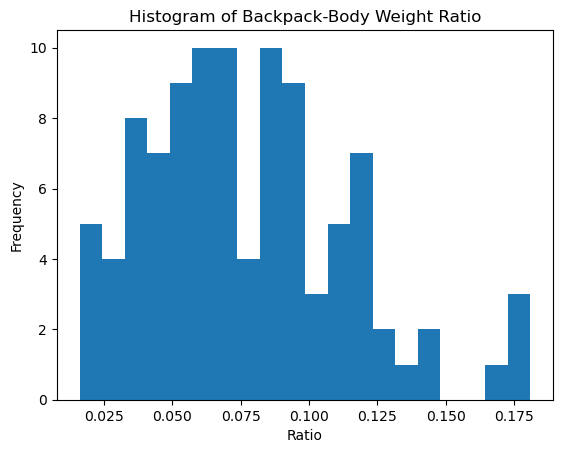

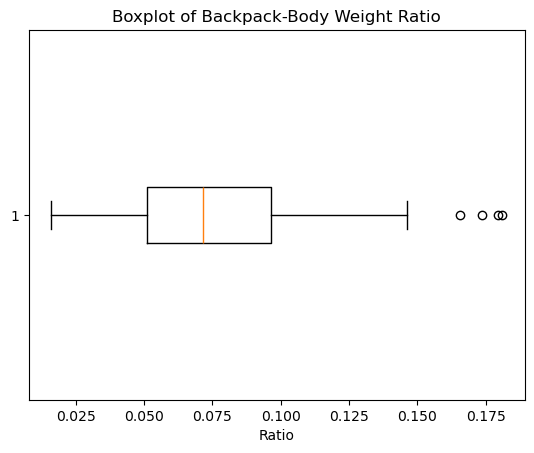

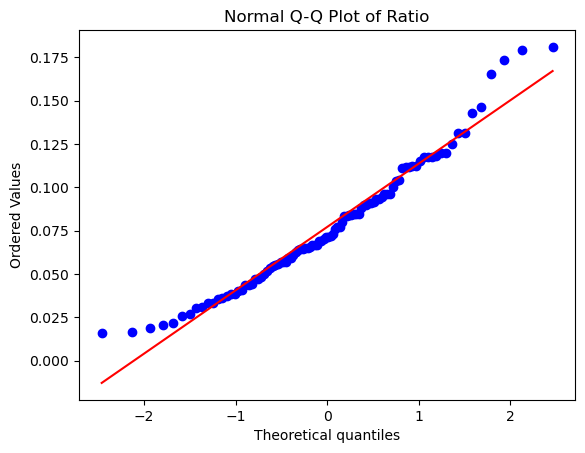

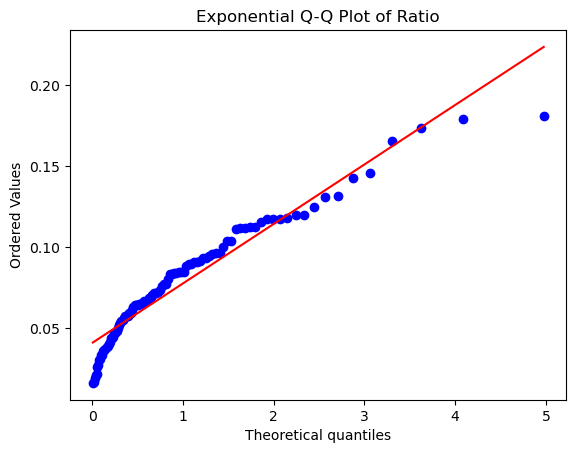

In [5]:
# Cell 5: Visualizations

# Histogram of ratio
plt.figure()
plt.hist(df['ratio'].dropna(), bins=20)
plt.title("Histogram of Backpack-Body Weight Ratio")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

# Boxplot of ratio
plt.figure()
plt.boxplot(df['ratio'].dropna(), vert=False)
plt.title("Boxplot of Backpack-Body Weight Ratio")
plt.xlabel("Ratio")
plt.show()

# Scatter plot: Backpack vs Body weight
if {'BackpackWeight','BodyWeight'}.issubset(df.columns):
    plt.figure()
    plt.scatter(df['BodyWeight'], df['BackpackWeight'])
    plt.title("Backpack Weight vs Body Weight")
    plt.xlabel("Body Weight")
    plt.ylabel("Backpack Weight")
    plt.show()

# Q-Q plot for normal distribution
plt.figure()
stats.probplot(df['ratio'].dropna(), dist='norm', plot=plt)
plt.title("Normal Q-Q Plot of Ratio")
plt.show()

# Q-Q plot for exponential distribution
plt.figure()
stats.probplot(df['ratio'].dropna(), dist='expon', plot=plt)
plt.title("Exponential Q-Q Plot of Ratio")
plt.show()

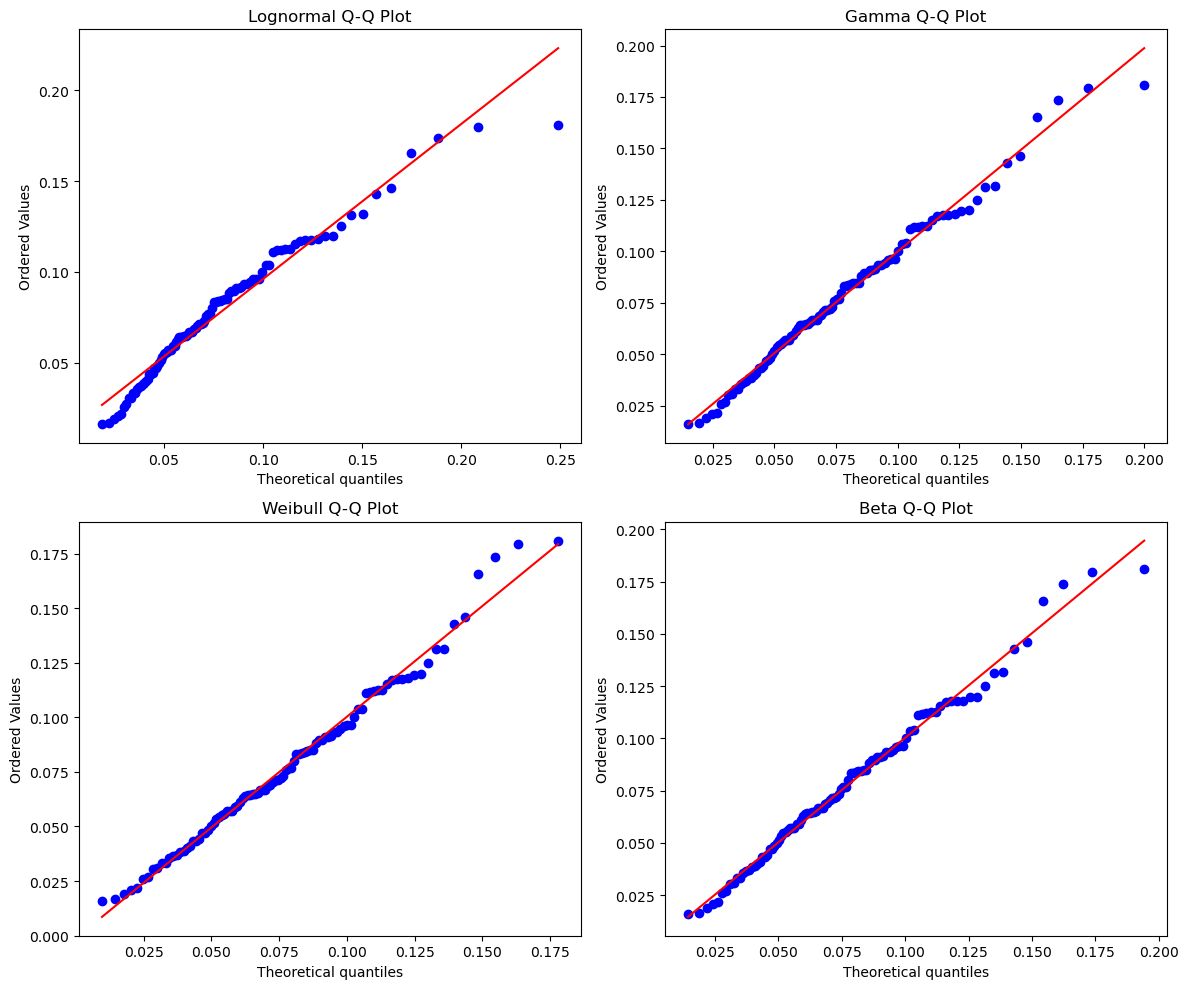

In [6]:
# Cell 5: Other possible Q-Q plot visualizations.

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = df['ratio'].dropna().values

# 1) Lognormal (force loc=0)
ln_shape, ln_loc, ln_scale = stats.lognorm.fit(data, floc=0)
# 2) Gamma   (force loc=0)
gm_a, gm_loc, gm_scale = stats.gamma.fit(data, floc=0)
# 3) Weibull (force loc=0)
wb_c, wb_loc, wb_scale = stats.weibull_min.fit(data, floc=0)
# 4) Beta    (force to [0,1])
bt_a, bt_b, bt_loc, bt_scale = stats.beta.fit(data, floc=0, fscale=1)

candidates = {
    'Lognormal':    (stats.lognorm,     (ln_shape, ln_loc, ln_scale)),
    'Gamma':        (stats.gamma,       (gm_a,    gm_loc,    gm_scale)),
    'Weibull':      (stats.weibull_min, (wb_c,    wb_loc,    wb_scale)),
    'Beta':         (stats.beta,        (bt_a,    bt_b,      bt_loc, bt_scale)),
}

plt.figure(figsize=(12, 10))
for i, (name, (dist, params)) in enumerate(candidates.items(), 1):
    ax = plt.subplot(2, 2, i)
    stats.probplot(data, dist=dist, sparams=params, plot=ax)
    ax.set_title(f"{name} Q-Q Plot")
plt.tight_layout()
plt.show()


Goodness-of-Fit (KS test) results:
Distribution        D    p-value
Weibull        0.0468     0.9737
Beta           0.0519     0.9379
Gamma          0.0567     0.8867
Normal         0.0759     0.5851
Lognormal      0.0830     0.4713
Exponential    0.2609     0.0000

→ Best fitting distribution: Weibull (D = 0.0468, p = 0.9737)


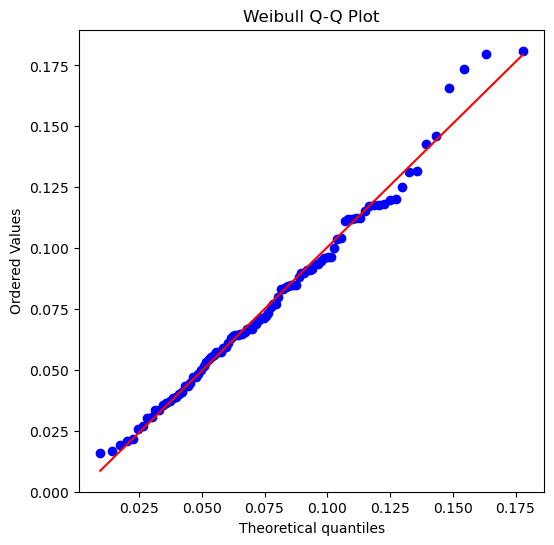

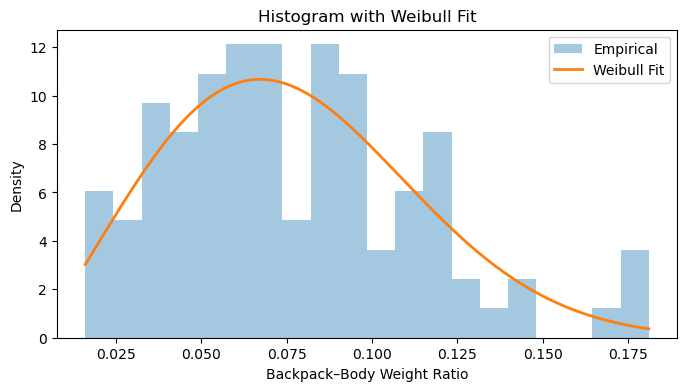

In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Ensure 'df' and 'df["ratio"]' are already defined from your previous cells
data = df['ratio'].dropna().values

# 1) Fit candidate distributions
distributions = {
    'Normal':      (stats.norm,         stats.norm.fit(data)),
    'Exponential': (stats.expon,        stats.expon.fit(data, floc=0)),
    'Lognormal':   (stats.lognorm,      stats.lognorm.fit(data, floc=0)),
    'Gamma':       (stats.gamma,        stats.gamma.fit(data, floc=0)),
    'Weibull':     (stats.weibull_min,  stats.weibull_min.fit(data, floc=0)),
    'Beta':        (stats.beta,         stats.beta.fit(data, floc=0, fscale=1)),
}

# 2) Perform KS tests
gof_results = []
for name, (dist, params) in distributions.items():
    D, p = stats.kstest(data, dist.name, args=params)
    gof_results.append((name, D, p))

# Sort by descending p-value (better fit = higher p)
gof_results.sort(key=lambda x: x[2], reverse=True)

# 3) Print GOF table
print("Goodness-of-Fit (KS test) results:")
print(f"{'Distribution':12s} {'D':>8s} {'p-value':>10s}")
for name, D, p in gof_results:
    print(f"{name:12s} {D:8.4f} {p:10.4f}")

best_name, best_D, best_p = gof_results[0]
print(f"\n→ Best fitting distribution: {best_name} (D = {best_D:.4f}, p = {best_p:.4f})")

# 4) Visualize the best (Weibull) fit
shape, loc, scale = distributions['Weibull'][1]

# Q-Q plot for Weibull
plt.figure(figsize=(6,6))
stats.probplot(data, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=plt)
plt.title("Weibull Q-Q Plot")
plt.show()

# Histogram + Weibull PDF overlay
x = np.linspace(data.min(), data.max(), 200)
pdf = stats.weibull_min.pdf(x, shape, loc=loc, scale=scale)

plt.figure(figsize=(8,4))
plt.hist(data, bins=20, density=True, alpha=0.4, label='Empirical')
plt.plot(x, pdf, lw=2, label='Weibull Fit')
plt.title("Histogram with Weibull Fit")
plt.xlabel("Backpack–Body Weight Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()


In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 1) grab your cleaned ratio array
data = df['ratio'].dropna().values

# 2) fit Weibull (force loc=0)
shape, loc, scale = stats.weibull_min.fit(data, floc=0)
print(f"Weibull parameters:\n  shape (c) = {shape:.4f}\n  loc       = {loc:.4f}\n  scale (λ) = {scale:.4f}")


Weibull parameters:
  shape (c) = 2.2501
  loc       = 0.0000
  scale (λ) = 0.0872


In [9]:
# Cell 6: 95% Confidence Interval for mean ratio
clean = df['ratio'].dropna()
n = clean.size
mean = clean.mean()
sem = stats.sem(clean)
ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=sem)
print(f"\n95% CI for mean ratio: [{ci_low:.4f}, {ci_high:.4f}]")



95% CI for mean ratio: [0.0699, 0.0844]


In [10]:
import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower, NormalIndPower, FTestPower
from statsmodels.stats.proportion import proportion_effectsize
import warnings

warnings.filterwarnings('ignore')

# Assumes you've already run Cells 1-3 so that `df` exists and has:
# - df['ratio'] (backpack-body weight ratio)
# - df['BackProblems'] (True/False)
# - df['Gender'] ('Female'/'Male')
# - df['Year'], df['Units']

# 1) Sample sizes for t-test
n_back    = df['BackProblems'].sum()
n_no_back = df['BackProblems'].shape[0] - n_back

# 2) Sample sizes & effect for proportion test
counts = df.groupby('Gender')['BackProblems'].agg(['sum', 'count'])
n_f = counts.loc['Female', 'count']
n_m = counts.loc['Male',   'count']
p1 = counts.loc['Female', 'sum'] / n_f
p2 = counts.loc['Male',   'sum'] / n_m
es_prop = proportion_effectsize(p1, p2)

# 3) Sample sizes & variance ratio for F-test
df['ClassGroup'] = df['Year'].apply(lambda x: 'Upper' if x >= 3 else 'Lower')
units_upper = df[df['ClassGroup'] == 'Upper']['Units']
units_lower = df[df['ClassGroup'] == 'Lower']['Units']
n_upper = units_upper.size
n_lower = units_lower.size
var_ratio_obs = units_upper.var(ddof=1) / units_lower.var(ddof=1)

# Define alphas and effect-size scenarios
alphas = [0.01, 0.05, 0.10]
effect_sizes_t = {'small': 0.2, 'medium': 0.5, 'large': 0.8}

# 4) Power analysis for two-sample t-test
ttest = TTestIndPower()
t_results = []
for label, es in effect_sizes_t.items():
    for alpha in alphas:
        power = ttest.power(effect_size=es, nobs1=n_back,
                             ratio=n_no_back / n_back, alpha=alpha)
        t_results.append({'Cohen d': es, 'alpha': alpha, 'power': power})
df_t = pd.DataFrame(t_results)

# 5) Power analysis for two-proportion z-test
prop_power = NormalIndPower()
p_results = []
for alpha in alphas:
    power = prop_power.power(effect_size=es_prop, nobs1=n_f,
                             ratio=n_m / n_f, alpha=alpha)
    p_results.append({'Effect size (h)': es_prop, 'alpha': alpha, 'power': power})
df_p = pd.DataFrame(p_results)

# 6) Power analysis for F-test on variance ratio
ftest = FTestPower()
v_results = []
for alpha in alphas:
    power = ftest.power(effect_size=var_ratio_obs, df_num=n_upper-1,
                         df_denom=n_lower-1, alpha=alpha)
    v_results.append({'Variance ratio': var_ratio_obs, 'alpha': alpha, 'power': power})
df_v = pd.DataFrame(v_results)

# 7) Display tables
print("Two-sample t-test power analysis:\n")
display(df_t)

print("Two-proportion z-test power analysis:\n")
display(df_p)

print("F-test (variance ratio) power analysis:\n")
display(df_v)

# 8) Suggest alpha for 80% power
print("\nSuggested alpha levels for 80% power:")
# t-test suggestions
for label, es in effect_sizes_t.items():
    subset = df_t[df_t['Cohen d'] == es]
    suitable = subset[subset['power'] >= 0.8]
    if not suitable.empty:
        best = suitable.nsmallest(1, 'alpha').iloc[0]
        print(f" - t-test (d={label}={es}): alpha ≈ {best['alpha']} (power={best['power']:.2f})")
    else:
        print(f" - t-test (d={label}={es}): power <0.8 even at alpha={max(alphas)}")

# proportion test suggestion
suitable_p = df_p[df_p['power'] >= 0.8]
if not suitable_p.empty:
    best_p = suitable_p.nsmallest(1, 'alpha').iloc[0]
    print(f" - proportion (h={es_prop:.2f}): alpha ≈ {best_p['alpha']} (power={best_p['power']:.2f})")
else:
    print(f" - proportion (h={es_prop:.2f}): power <0.8 even at alpha={max(alphas)}")

# variance test suggestion
suitable_v = df_v[df_v['power'] >= 0.8]
if not suitable_v.empty:
    best_v = suitable_v.nsmallest(1, 'alpha').iloc[0]
    print(f" - variance ratio (ratio={var_ratio_obs:.2f}): alpha ≈ {best_v['alpha']} (power={best_v['power']:.2f})")
else:
    print(f" - variance ratio (ratio={var_ratio_obs:.2f}): power <0.8 even at alpha={max(alphas)}")



Two-sample t-test power analysis:



,Cohen d,alpha,power
0,0.2,0.01,0.048842
1,0.2,0.05,0.152035
2,0.2,0.10,0.241339
3,0.5,0.01,0.388641
4,0.5,0.05,0.636658
5,0.5,0.10,0.749047
6,0.8,0.01,0.862702
7,0.8,0.05,0.958632
8,0.8,0.10,0.980349


Two-proportion z-test power analysis:



,Effect size (h),alpha,power
0,0.572678,0.01,0.607653
1,0.572678,0.05,0.813018
2,0.572678,0.10,0.885744


F-test (variance ratio) power analysis:



,Variance ratio,alpha,power
0,0.767453,0.01,0.920873
1,0.767453,0.05,0.983821
2,0.767453,0.10,0.994177



Suggested alpha levels for 80% power:
 - t-test (d=small=0.2): power <0.8 even at alpha=0.1
 - t-test (d=medium=0.5): power <0.8 even at alpha=0.1
 - t-test (d=large=0.8): alpha ≈ 0.01 (power=0.86)
 - proportion (h=0.57): alpha ≈ 0.05 (power=0.81)
 - variance ratio (ratio=0.77): alpha ≈ 0.01 (power=0.92)


In [11]:
# Cell 7: Hypothesis Test 1 – Two-sample t-test (ratio by back problems)
grp_back = df[df['BackProblems'] == True]['ratio'].dropna()
grp_no_back = df[df['BackProblems'] == False]['ratio'].dropna()
t_stat, p_val = stats.ttest_ind(grp_back, grp_no_back, equal_var=False)
print(f"\nT-test (back problems): t = {t_stat:.3f}, p = {p_val:.3f}")



T-test (back problems): t = 1.857, p = 0.068


In [12]:
# Cell 8: Hypothesis Test 2 – Two-proportion z-test (back problems by gender)
# 1) Rebuild the crosstab
cont = pd.crosstab(df['Gender'], df['BackProblems'])
print("\nCounts by Gender & BackProblems:\n", cont)

# 2) For “with back problems” use the column 1, and total = row sum
count_women = cont.loc['Female', 1]
n_women     = cont.loc['Female'].sum()
count_men   = cont.loc['Male',   1]
n_men       = cont.loc['Male'].sum()

# 3) Two‐proportion z‐test
from statsmodels.stats.proportion import proportions_ztest
counts = np.array([count_women, count_men])
nobs   = np.array([n_women,    n_men])
z_stat, p_val = proportions_ztest(counts, nobs)
print(f"\nProportion Z-test: z = {z_stat:.3f}, p = {p_val:.3f}")



Counts by Gender & BackProblems:
 BackProblems   0   1
Gender              
Female        31  24
Male          37   8

Proportion Z-test: z = 2.758, p = 0.006


In [13]:
# Cell 9: Hypothesis Test 3 – Variance comparison (F-test) Units by class group
df['ClassGroup'] = df['Year'].apply(lambda x: 'Upper (3+)' if x >= 3 else 'Lower (1-2)')
units_upper = df[df['ClassGroup'] == 'Upper (3+)']['Units'].dropna()
units_lower = df[df['ClassGroup'] == 'Lower (1-2)']['Units'].dropna()
var_upper = units_upper.var(ddof=1)
var_lower = units_lower.var(ddof=1)
F = var_upper / var_lower
df1 = units_upper.size - 1
df2 = units_lower.size - 1
p_var = 1 - stats.f.cdf(F, df1, df2)
print(f"\nF-test (variance Units): F = {F:.3f}, p = {p_var:.3f}")


F-test (variance Units): F = 0.767, p = 0.818
